# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [60]:
import os
import io
import base64
from typing import List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from collections import defaultdict
from PIL import Image, ImageDraw
import contextlib

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs
from rdkit.DataStructs import TanimotoSimilarity

from joblib import Parallel, delayed
from sklearn.manifold import MDS, TSNE

# Pandas display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

### Define directories
***

In [61]:
# Set user directory
USER_DIR = os.path.expanduser('~')

# Set the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the input and output directories
INPUT_DIR = os.path.join(PROJECT_ROOT, 'data/bit_flipping_nn_review_2')

### Load Parecoxib, Celecoxib, Cimicoxib and Deracoxib, Anitrazafen Data
***

In [62]:


anitrazafen_df_2 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_2_random_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_2.shape}")

Anitrazafen shape: (1024, 9)


In [63]:


anitrazafen_df_4 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_4_random_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_4.shape}")

Anitrazafen shape: (512, 9)


In [64]:


anitrazafen_df_8 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_8_random_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_8.shape}")

Anitrazafen shape: (256, 9)


In [65]:


anitrazafen_df_128 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_128_random_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_128.shape}")

Anitrazafen shape: (16, 9)


In [66]:


anitrazafen_df_1024 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_1024_random_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_1024.shape}")

Anitrazafen shape: (2, 9)


### Validate generated SMILES
***

In [67]:
# Function to convert SMILES to molecule and check validity
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None, mol

In [68]:

anitrazafen_df_2['Valid_SMILES'], anitrazafen_df_2['Molecule'] = zip(*anitrazafen_df_2['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))

anitrazafen_df_4['Valid_SMILES'], anitrazafen_df_4['Molecule'] = zip(*anitrazafen_df_4['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))


anitrazafen_df_8['Valid_SMILES'], anitrazafen_df_8['Molecule'] = zip(*anitrazafen_df_8['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))


anitrazafen_df_128['Valid_SMILES'], anitrazafen_df_128['Molecule'] = zip(*anitrazafen_df_128['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))


anitrazafen_df_1024['Valid_SMILES'], anitrazafen_df_1024['Molecule'] = zip(*anitrazafen_df_1024['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))


[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Err

In [69]:
def calculate_valid_smiles_percentage(df_dict):
    results = []
    
    for compound, df in df_dict.items():
        valid_smiles = df['Valid_SMILES'].sum()
        percentage = df['Valid_SMILES'].mean() * 100
        results.append({
            'Compound': compound,
            'Valid_SMILES': valid_smiles,
            'Percentage': percentage
        })
    
    return pd.DataFrame(results)

### Generate ECFP4 Fingerprints of Generated SMILES
***

In [70]:
def generate_fingerprints_for_predictions_dict(df_dict, n_jobs=-1):
    """
    Generate ECFP4 fingerprints for predicted SMILES strings using parallel processing.
    """
    def process_single_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
            fp = morgan_generator.GetFingerprint(mol)
            bit_vector = np.array(list(fp.ToBitString())).astype(int)
            sparse_representation = list(np.where(bit_vector == 1)[0])
            sparse_representation_str = ' '.join(map(str, sparse_representation))
            return bit_vector, sparse_representation_str
        return None, None

    updated_dict = {}
    
    for molecule_name, df in df_dict.items():
        print(f"Processing {molecule_name}...")
        
        # Use parallel processing to generate fingerprints
        with ThreadPoolExecutor(max_workers=n_jobs if n_jobs > 0 else None) as executor:
            results = list(executor.map(process_single_smiles, df['Generated_SMILES']))
        
        # Split results into separate lists
        bit_vectors, sparse_representations = zip(*results)
        
        # Create a copy of the DataFrame and add the new columns
        df_copy = df.copy()
        df_copy['GeneratedFingerprintBits'] = bit_vectors
        df_copy['GeneratedFingerprintSparse'] = sparse_representations
        
        # Store updated DataFrame in new dictionary
        updated_dict[molecule_name] = df_copy
    
    return updated_dict

def compare_fingerprints_dict(df_dict):
    """
    Compare original and generated fingerprints to verify they're different.
    """
    results = {}
    
    for molecule_name, df in df_dict.items():
        different_fps = df.apply(
            lambda row: not np.array_equal(row['FingerprintBits'], 
                                         row['GeneratedFingerprintBits']), 
            axis=1
        ).sum()
        
        total = len(df)
        results[molecule_name] = {
            'different_fps': different_fps,
            'total': total,
            'percentage': (different_fps/total) * 100
        }
        
    return results

In [71]:
anitrazafen_df_2 = generate_fingerprints_for_predictions_dict({'Anitrazafen': anitrazafen_df_2})['Anitrazafen']

anitrazafen_df_4 = generate_fingerprints_for_predictions_dict({'Anitrazafen': anitrazafen_df_4})['Anitrazafen']

anitrazafen_df_8 = generate_fingerprints_for_predictions_dict({'Anitrazafen': anitrazafen_df_8})['Anitrazafen']

anitrazafen_df_128 = generate_fingerprints_for_predictions_dict({'Anitrazafen': anitrazafen_df_128})['Anitrazafen']

anitrazafen_df_1024 = generate_fingerprints_for_predictions_dict({'Anitrazafen': anitrazafen_df_1024})['Anitrazafen']


Processing Anitrazafen...
Processing Anitrazafen...


[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:42] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Err

Processing Anitrazafen...
Processing Anitrazafen...
Processing Anitrazafen...


[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:43] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:43] SMILES Parse Err

In [72]:
# Compare results for each dataset
for n_flips, dfs in [
    (2, [anitrazafen_df_2]),
    (4, [anitrazafen_df_4]),
    (8, [anitrazafen_df_8]),
    (128, [anitrazafen_df_128]),
    (1024, [anitrazafen_df_1024])
]:
    print(f"\nResults for {n_flips} flips:")
    for df, name in zip(dfs, ['Anitrazafen']):
        different_fps = df.apply(
            lambda row: not np.array_equal(row['FingerprintBitsFlipped'], 
                                         row['GeneratedFingerprintBits']), 
            axis=1
        ).sum()
        total = len(df)
        percentage = (different_fps/total) * 100
        print(f"{name}: {different_fps}/{total} fingerprints are different ({percentage:.2f}%)")


Results for 2 flips:
Anitrazafen: 1024/1024 fingerprints are different (100.00%)

Results for 4 flips:
Anitrazafen: 512/512 fingerprints are different (100.00%)

Results for 8 flips:
Anitrazafen: 256/256 fingerprints are different (100.00%)

Results for 128 flips:
Anitrazafen: 16/16 fingerprints are different (100.00%)

Results for 1024 flips:
Anitrazafen: 2/2 fingerprints are different (100.00%)


### Tanimoto similarity
***

In [73]:
def calculate_tanimoto_safe(fp_bits1, fp_bits2):
    """
    Calculate Tanimoto similarity between two fingerprint bit vectors.
    Handles None values and suppresses error messages.
    """
    try:
        # Check for None values
        if fp_bits1 is None or fp_bits2 is None:
            return None
            
        # Convert bit vectors to numpy arrays if they aren't already
        fp_bits1 = np.array(list(fp_bits1))  # Convert to list first
        fp_bits2 = np.array(list(fp_bits2))  # Convert to list first
        
        # Verify that both fingerprints have the same length
        if len(fp_bits1) != len(fp_bits2):
            return None
            
        # Calculate intersection (AND) and union (OR)
        intersection = np.sum(fp_bits1 & fp_bits2)
        union = np.sum(fp_bits1 | fp_bits2)
        
        # Avoid division by zero
        if union == 0:
            return 0.0
            
        # Calculate Tanimoto similarity
        tanimoto = intersection / union
        
        return float(tanimoto)
        
    except Exception as e:
        return None

In [74]:

anitrazafen_df_2['Tanimoto'] = anitrazafen_df_2.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)


anitrazafen_df_4['Tanimoto'] = anitrazafen_df_4.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)


anitrazafen_df_8['Tanimoto'] = anitrazafen_df_8.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)


anitrazafen_df_128['Tanimoto'] = anitrazafen_df_128.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)


anitrazafen_df_1024['Tanimoto'] = anitrazafen_df_1024.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)

In [75]:
# Calculate Tanimoto2 for 2 flips

anitrazafen_df_2['Tanimoto2'] = anitrazafen_df_2.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['GeneratedFingerprintBits']), axis=1)

# Calculate Tanimoto2 for 4 flips

anitrazafen_df_4['Tanimoto2'] = anitrazafen_df_4.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['GeneratedFingerprintBits']), axis=1)

# Calculate Tanimoto2 for 8 flips

anitrazafen_df_8['Tanimoto2'] = anitrazafen_df_8.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['GeneratedFingerprintBits']), axis=1)

# Calculate Tanimoto2 for 128 flips

anitrazafen_df_128['Tanimoto2'] = anitrazafen_df_128.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['GeneratedFingerprintBits']), axis=1)

# Calculate Tanimoto2 for 1024 flips

anitrazafen_df_1024['Tanimoto2'] = anitrazafen_df_1024.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['GeneratedFingerprintBits']), axis=1)

In [76]:
def print_average_similarities(flip_count):
    """
    Calculate and print average Tanimoto similarities for both flipped fingerprints and generated SMILES.
    """
    molecules = ['anitrazafen']
    
    print(f'\n*** {flip_count} random flips ***')
    
    # Print Tanimoto similarities for flipped fingerprints
    print("--- Tanimoto Similarity (Flipped Fingerprints) ---")
    for molecule in molecules:
        df = globals()[f'{molecule}_df_{flip_count}']
        avg_similarity = df['Tanimoto'].mean()
        print(f"Average Tanimoto Similarity for {flip_count} random flips {molecule.capitalize()}: {avg_similarity}")
    
    # Print Tanimoto similarities for generated SMILES
    print("\n--- Tanimoto Similarity (Generated SMILES) ---")
    for molecule in molecules:
        df = globals()[f'{molecule}_df_{flip_count}']
        avg_similarity2 = df['Tanimoto2'].mean()
        print(f"Average Tanimoto2 Similarity for {flip_count} random flips {molecule.capitalize()}: {avg_similarity2}")

In [77]:
# Calculate and print similarities for each flip count
for flips in [2, 4, 8, 128, 1024]:
    print_average_similarities(flips)


*** 2 random flips ***
--- Tanimoto Similarity (Flipped Fingerprints) ---
Average Tanimoto Similarity for 2 random flips Anitrazafen: 0.9285042576058202

--- Tanimoto Similarity (Generated SMILES) ---
Average Tanimoto2 Similarity for 2 random flips Anitrazafen: 0.9918509906735992

*** 4 random flips ***
--- Tanimoto Similarity (Flipped Fingerprints) ---
Average Tanimoto Similarity for 4 random flips Anitrazafen: 0.8664325482348115

--- Tanimoto Similarity (Generated SMILES) ---
Average Tanimoto2 Similarity for 4 random flips Anitrazafen: 0.7893804018588264

*** 8 random flips ***
--- Tanimoto Similarity (Flipped Fingerprints) ---
Average Tanimoto Similarity for 8 random flips Anitrazafen: 0.7639817290552586

--- Tanimoto Similarity (Generated SMILES) ---
Average Tanimoto2 Similarity for 8 random flips Anitrazafen: 0.6471832815513388

*** 128 random flips ***
--- Tanimoto Similarity (Flipped Fingerprints) ---
Average Tanimoto Similarity for 128 random flips Anitrazafen: 0.1599178891853

In [78]:
def plot_similarity_distribution(df, molecule_name, n_flips):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot Tanimoto (Flipped Fingerprints)
    sns.histplot(data=df['Tanimoto'], bins=20, kde=True, ax=ax1)
    ax1.set_title(f'Similarity Distribution (Flipped Fingerprints)\n{molecule_name} ({n_flips} flips)')
    ax1.set_xlabel('Tanimoto Similarity')
    ax1.set_ylabel('Count')
    
    # Plot Tanimoto2 (Generated SMILES)
    sns.histplot(data=df['Tanimoto2'], bins=20, kde=True, ax=ax2)
    ax2.set_title(f'Similarity Distribution (Generated SMILES)\n{molecule_name} ({n_flips} flips)')
    ax2.set_xlabel('Tanimoto Similarity')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

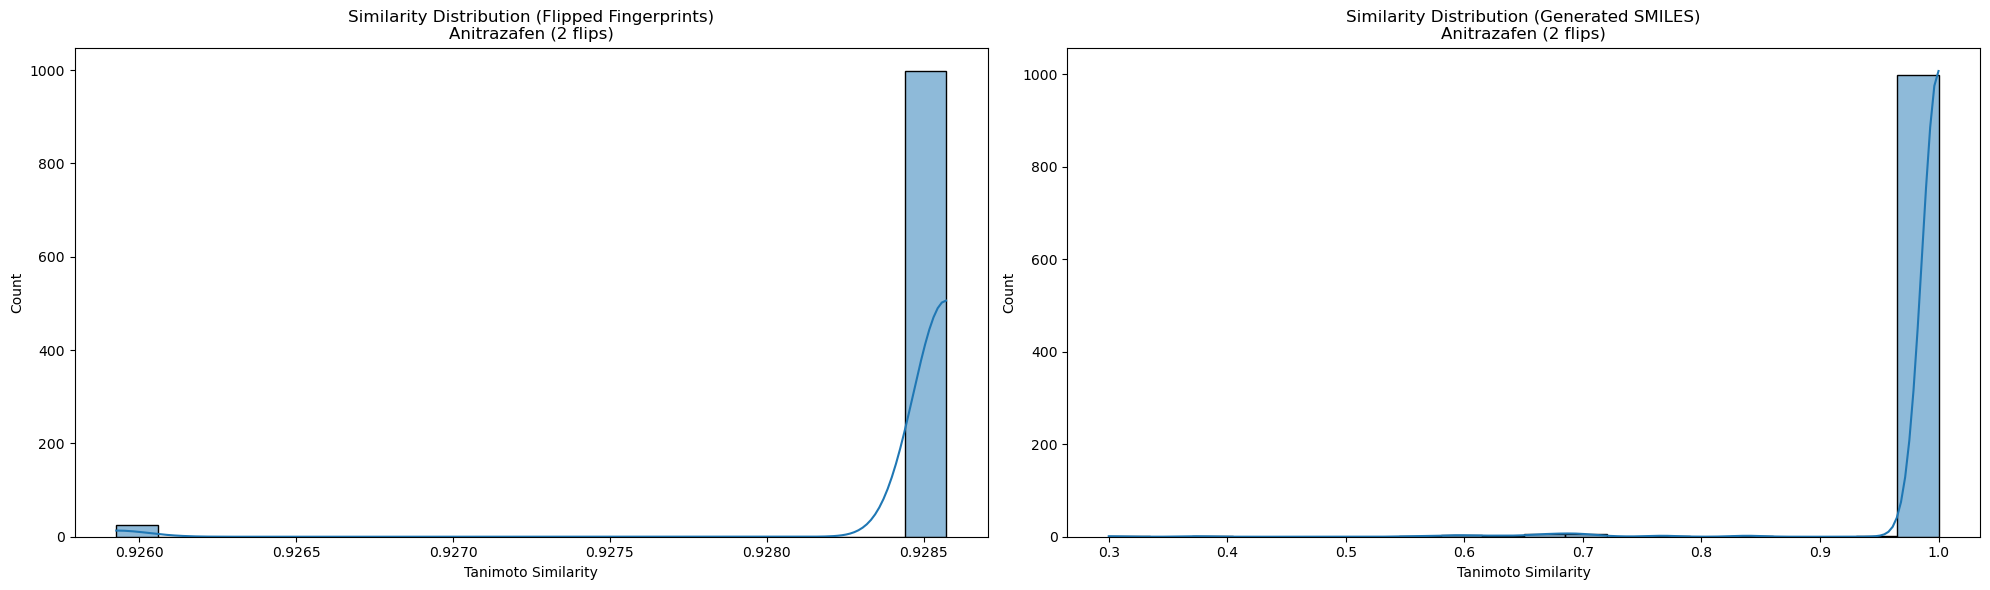

In [79]:

plot_similarity_distribution(anitrazafen_df_2, 'Anitrazafen', 2)

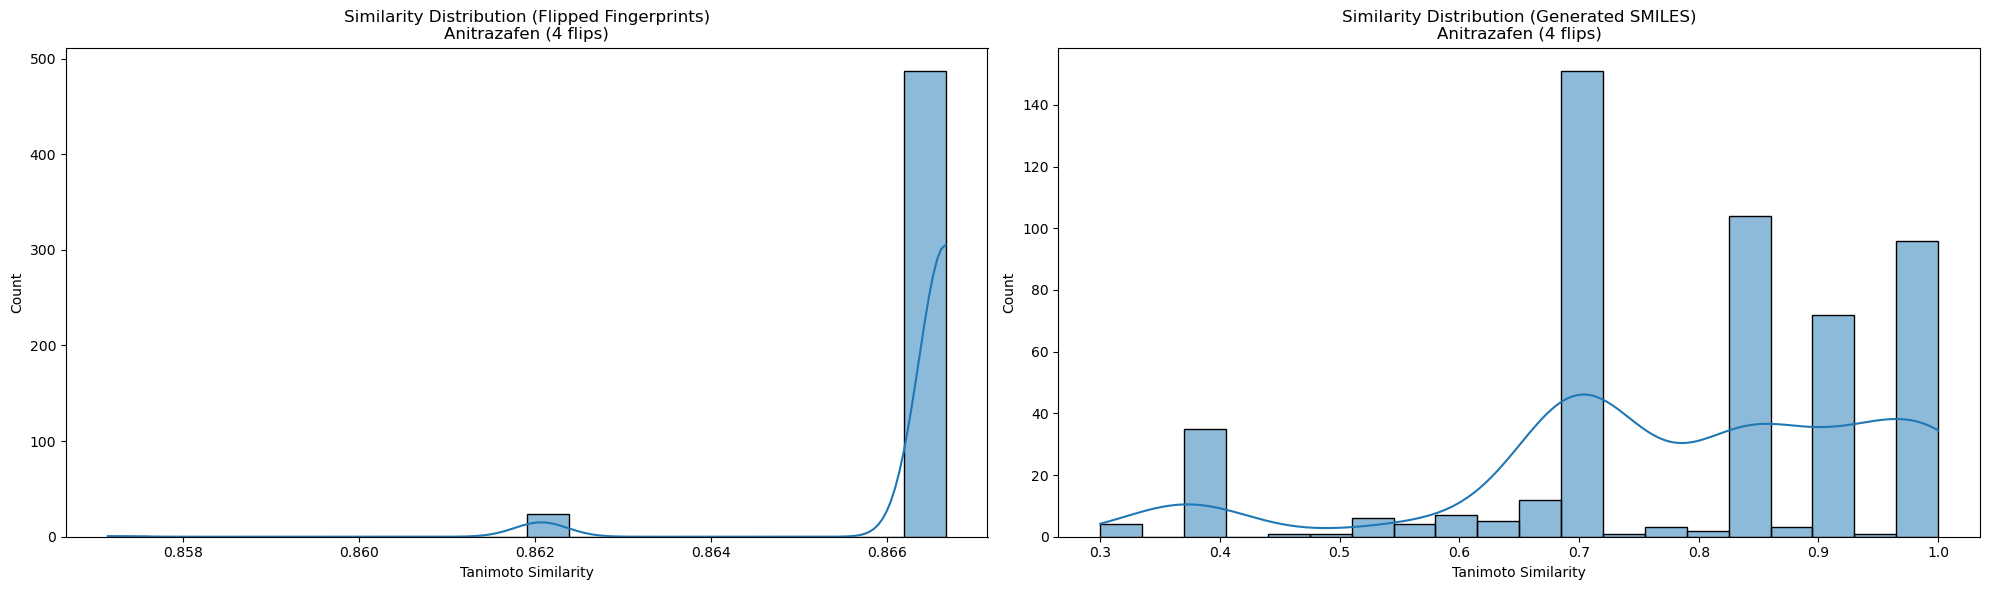

In [80]:

plot_similarity_distribution(anitrazafen_df_4, 'Anitrazafen', 4)

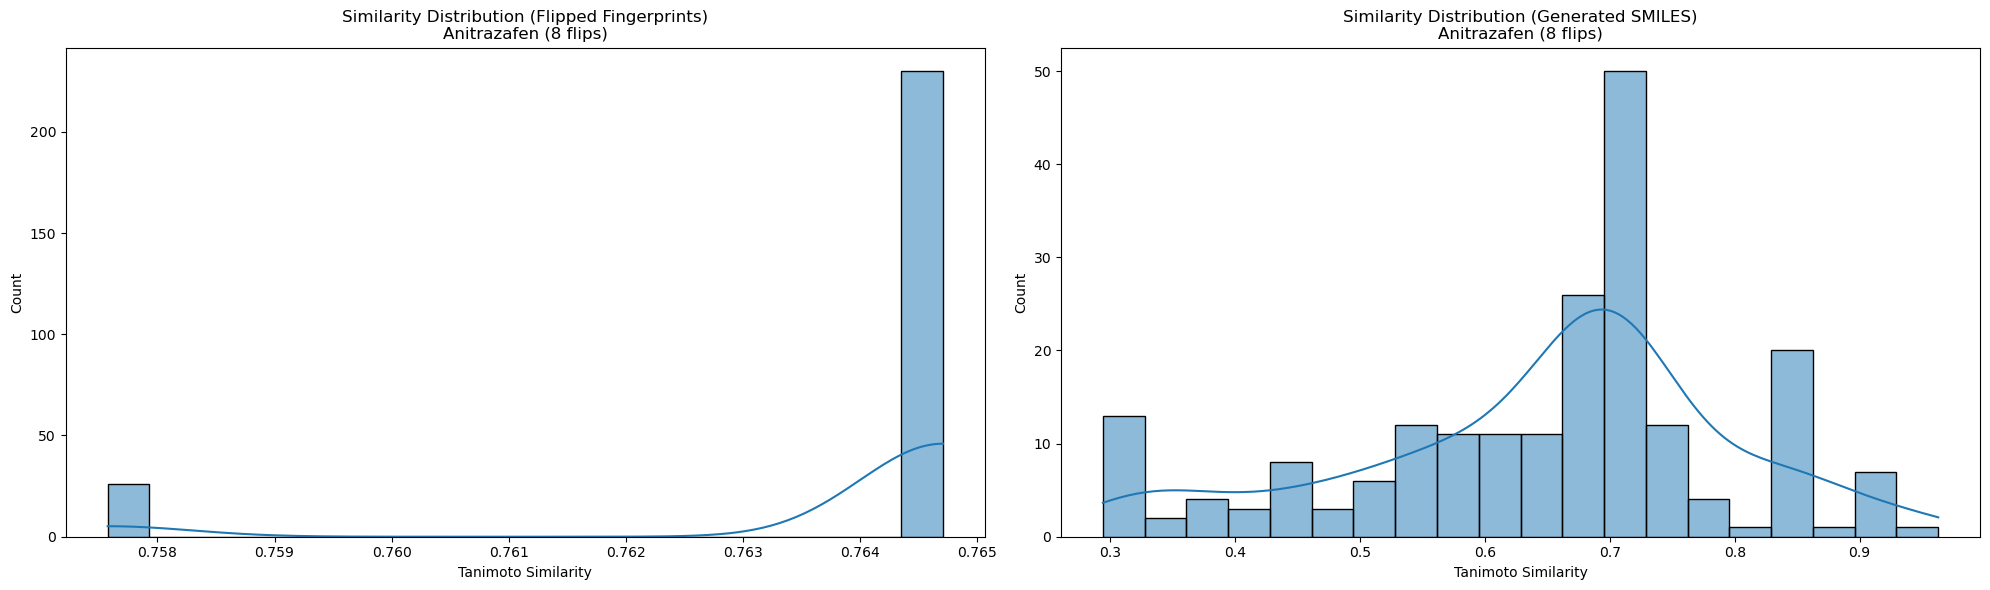

In [81]:

plot_similarity_distribution(anitrazafen_df_8, 'Anitrazafen', 8)

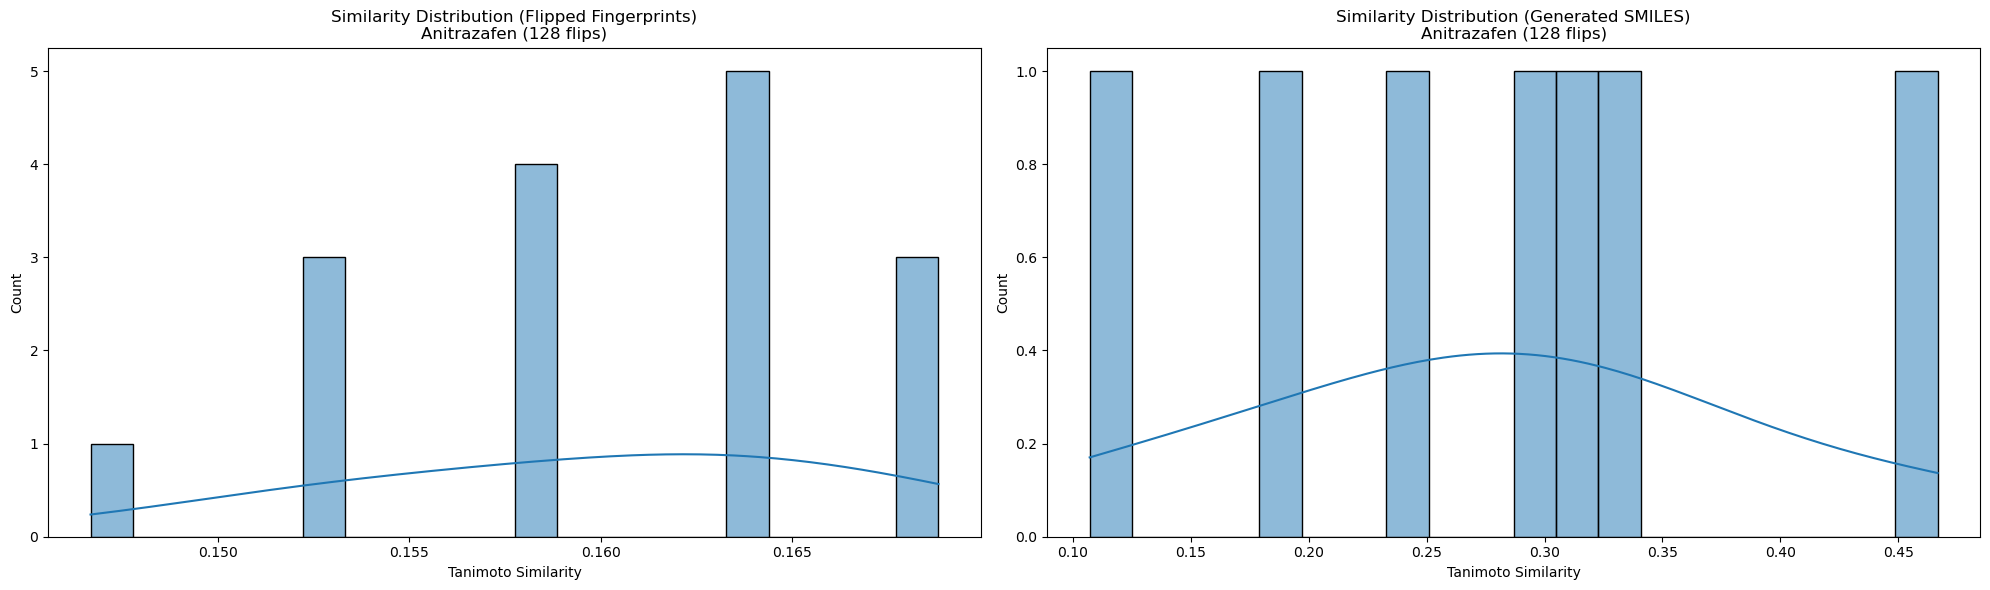

In [82]:

plot_similarity_distribution(anitrazafen_df_128, 'Anitrazafen', 128)

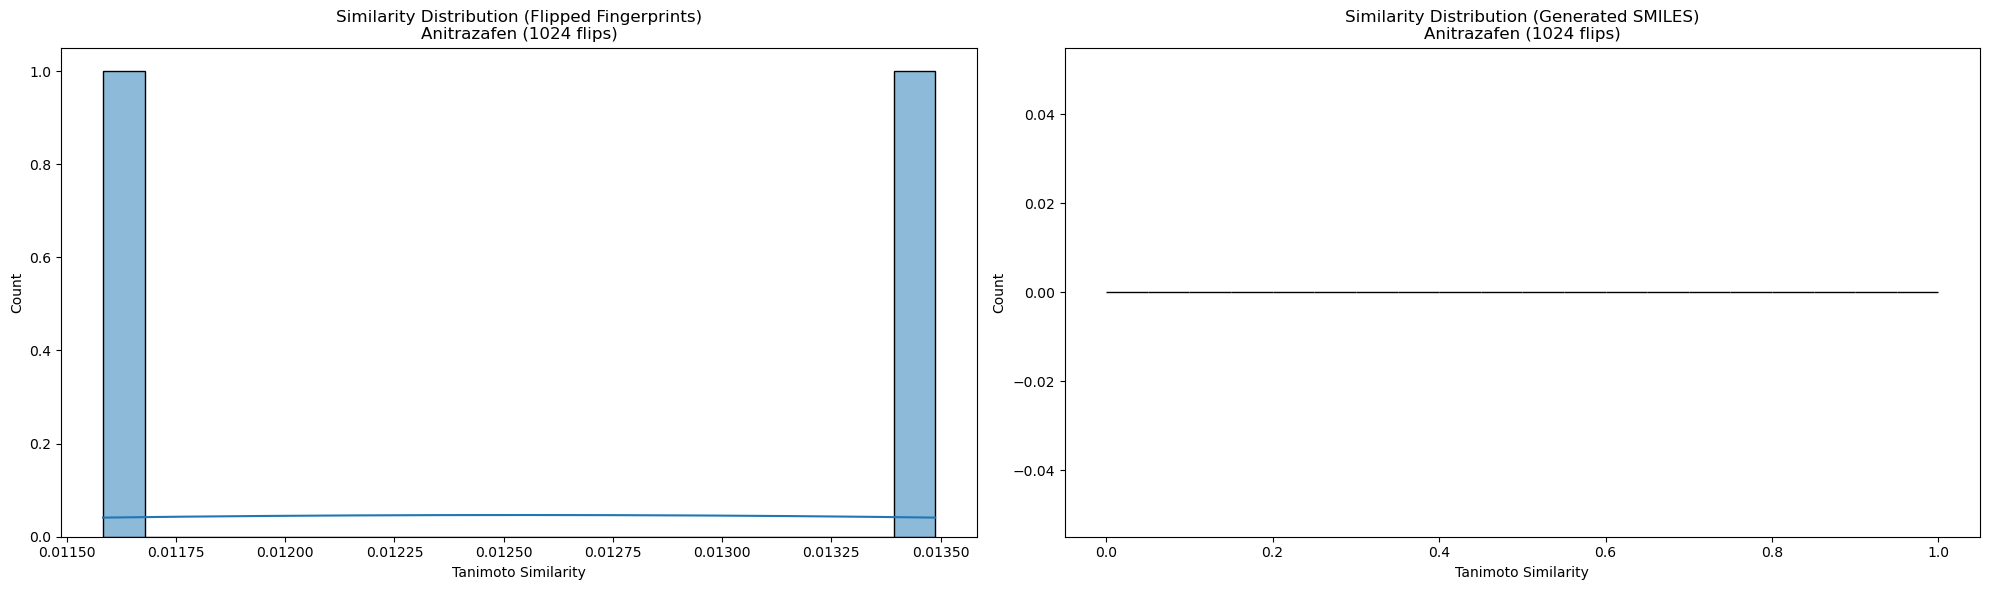

In [83]:

plot_similarity_distribution(anitrazafen_df_1024, 'Anitrazafen', 1024)

### Plot generated molecules
***

In [84]:
def mol_to_image(mol):
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    if mol is None:
        return None
    img = Draw.MolToImage(mol)
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()




def plot_unique_molecules(df, n_flips):
    molecule_name = df.iloc[0]['title'].lower()
    
    # Create a new column in df to store the original index
    df['original_index'] = df.index

    # Remove duplicates based on 'Generated_SMILES' but keep original indices
    df_unique = df.drop_duplicates(subset=['Generated_SMILES']).copy()
    
    n_rows = len(df_unique) + 1  # +1 for the original molecule
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 5*n_rows))
    
    # Plot original molecule
    original_mol = Chem.MolFromSmiles(df.iloc[0]['SMILES'])
    img = Draw.MolToImage(original_mol)
    axes[0].imshow(img)
    axes[0].set_title(f"Original Molecule: {df.iloc[0]['title']}\nSMILES: {df.iloc[0]['SMILES']}")
    axes[0].axis('off')
    
    # Plot unique generated molecules
    for i, row in enumerate(df_unique.iterrows(), start=1):
        img = mol_to_image(row[1]['Generated_SMILES'])
        if img:
            axes[i].imshow(Image.open(io.BytesIO(base64.b64decode(img))))
            axes[i].set_title(f"Generated Molecule {row[1]['original_index']} (Flipped Bits: {row[1]['FlippedBitPositions']})\n"
                              f"SMILES: {row[1]['Generated_SMILES']}\n"
                              f"Tanimoto = {row[1].get('Tanimoto2', 'N/A'):.2f}")
        else:
            axes[i].text(0.5, 0.5, "Invalid SMILES", ha='center', va='center')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(INPUT_DIR, f'{molecule_name}_{n_flips}_unique_flips.png'))
    plt.close(fig)


In [85]:

plot_unique_molecules(anitrazafen_df_2,2)


plot_unique_molecules(anitrazafen_df_4,4)


plot_unique_molecules(anitrazafen_df_8,8)


plot_unique_molecules(anitrazafen_df_128,128)


plot_unique_molecules(anitrazafen_df_1024,1024)

[18:52:46] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:46] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:48] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:48] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:53] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:53] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:53] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:53] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


In [86]:
def analyze_smiles_occurrences(df_2, df_4, df_8, df_128, df_1024, compound_name):
    # Get value counts for each dataset
    smiles_counts_2 = df_2['Generated_SMILES'].value_counts().to_dict()
    smiles_counts_4 = df_4['Generated_SMILES'].value_counts().to_dict()
    smiles_counts_8 = df_8['Generated_SMILES'].value_counts().to_dict()
    smiles_counts_128 = df_128['Generated_SMILES'].value_counts().to_dict()
    smiles_counts_1024 = df_1024['Generated_SMILES'].value_counts().to_dict()
    
    # Create result dictionary
    results = {
        'compound_name': compound_name,
        'datasets': {
            '2_flips': {
                'occurrences': smiles_counts_2,
                'total_unique': len(smiles_counts_2),
                'total_samples': len(df_2)
            },
            '4_flips': {
                'occurrences': smiles_counts_4,
                'total_unique': len(smiles_counts_4),
                'total_samples': len(df_4)
            },
            '8_flips': {
                'occurrences': smiles_counts_8,
                'total_unique': len(smiles_counts_8),
                'total_samples': len(df_8)
            },
            '128_flips': {
                'occurrences': smiles_counts_128,
                'total_unique': len(smiles_counts_128),
                'total_samples': len(df_128)
            },
            '1024_flips': {
                'occurrences': smiles_counts_1024,
                'total_unique': len(smiles_counts_1024),
                'total_samples': len(df_1024)
            }
        }
    }
    
    return results

### Plot the nearest neighbors
***

In [87]:
def generate_fingerprints(smiles_list):
    """Generate Morgan fingerprints for a list of SMILES strings."""
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
    fps = [morgan_generator.GetFingerprint(mol) for mol in mols if mol is not None]
    return fps

def calculate_similarity_matrix(fps):
    """Calculate Tanimoto similarity matrix for a list of fingerprints."""
    n = len(fps)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return similarity_matrix

def plot_mds_similarity(df, title_column='title', smiles_column='SMILES', 
                       generated_smiles_column='Generated_SMILES', n_flips=10):
    """Plot MDS similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    
    # Verify DataFrame is not empty
    if df.empty:
        print(f"Warning: Empty DataFrame for {title_column}")
        return
        
    try:
        # Store the original index in a new column (if it doesn't already exist)
        if 'original_index' not in df.columns:
            df['original_index'] = df.index

        # Extract SMILES (original + generated)
        original_smiles = df[smiles_column].iloc[0]
        generated_smiles = df[generated_smiles_column].tolist()
        
        # Verify we have SMILES to process
        if not generated_smiles:
            print(f"Warning: No generated SMILES found for {df[title_column].iloc[0]}")
            return
            
        all_smiles = [original_smiles] + generated_smiles

        # Generate fingerprints and calculate similarity matrix
        fps = generate_fingerprints(all_smiles)
        
        # Verify fingerprint generation was successful
        if not fps:
            print(f"Warning: Failed to generate fingerprints for {df[title_column].iloc[0]}")
            return
            
        similarity_matrix = calculate_similarity_matrix(fps)

        # Apply MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(1 - similarity_matrix)  # Convert similarity to distance

        # Calculate similarities to the original molecule
        similarities_to_original = similarity_matrix[0, 1:]

        # Create the plot
        plt.figure(figsize=(14, 10))
        
        # Plot generated SMILES with color indicating similarity to original
        scatter = plt.scatter(coords[1:, 0], coords[1:, 1], 
                            c=similarities_to_original, 
                            cmap='viridis', 
                            alpha=0.6, 
                            s=100)
        
        # Plot original SMILES in red
        plt.scatter(coords[0, 0], coords[0, 1], 
                   c='red', 
                   s=200, 
                   label='Original SMILES', 
                   edgecolors='black')

        # Add color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

        # Use the original index for labeling
        for i in range(len(coords)):
            if i == 0:
                label = "Original"
            else:
                original_index = df['original_index'].iloc[i-1]  # -1 because first item is original molecule
                label = f"{original_index}"

            plt.annotate(label, 
                        (coords[i, 0], coords[i, 1]), 
                        xytext=(5, 5),
                        textcoords='offset points', 
                        fontsize=8)

        # Add title and labels
        plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
        plt.xlabel("MDS Dimension 1")
        plt.ylabel("MDS Dimension 2")
        plt.legend()
        plt.tight_layout()
        
        # Save the figure
        filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_mds_similarity.png'
        plt.savefig(os.path.join(INPUT_DIR, filename))
        plt.close()
        
        return True
        
    except Exception as e:
        print(f"Error processing {df[title_column].iloc[0] if not df.empty else 'unknown'}: {str(e)}")
        plt.close()  # Ensure figure is closed even if error occurs
        return False


def process_and_plot(df, n_flips):
    """Process dataframe and generate plot with error handling."""
    try:
        success = plot_mds_similarity(df, n_flips=n_flips)
        if success:
            print(f"MDS plot saved for {df['title'].iloc[0]} with {n_flips} flips at a time.")
        else:
            print(f"Failed to create MDS plot for data with {n_flips} flips.")
    except Exception as e:
        print(f"Error in process_and_plot with {n_flips} flips: {str(e)}")


In [88]:

process_and_plot(anitrazafen_df_2,2)

process_and_plot(anitrazafen_df_4,4)


process_and_plot(anitrazafen_df_8,8)


process_and_plot(anitrazafen_df_128,128)


process_and_plot(anitrazafen_df_1024,1024)

MDS plot saved for Anitrazafen with 2 flips at a time.


[18:52:56] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:56] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:56] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:56] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:56] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:56] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:56] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:56] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


MDS plot saved for Anitrazafen with 4 flips at a time.


[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Err

MDS plot saved for Anitrazafen with 8 flips at a time.
MDS plot saved for Anitrazafen with 128 flips at a time.


[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:52:59] SMILES Parse Error: syntax error while parsing: Invalid
[18:52:59] SMILES Parse Err

MDS plot saved for Anitrazafen with 1024 flips at a time.


In [89]:
def plot_tsne_similarity(df, title_column='title', smiles_column='SMILES', 
                         generated_smiles_column='Generated_SMILES', n_flips=10):
    """Plot t-SNE similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    
    # Verify DataFrame is not empty
    if df.empty:
        print(f"Warning: Empty DataFrame for {title_column}")
        return False
        
    try:
        # Store the original index in a new column (if it doesn't already exist)
        if 'original_index' not in df.columns:
            df['original_index'] = df.index

        # Extract SMILES (original + generated)
        original_smiles = df[smiles_column].iloc[0]
        generated_smiles = df[generated_smiles_column].tolist()
        
        # Verify we have SMILES to process
        if not generated_smiles:
            print(f"Warning: No generated SMILES found for {df[title_column].iloc[0]}")
            return False
            
        all_smiles = [original_smiles] + generated_smiles

        # Generate fingerprints and calculate similarity matrix
        fps = generate_fingerprints(all_smiles)
        
        # Verify fingerprint generation was successful
        if not fps:
            print(f"Warning: Failed to generate fingerprints for {df[title_column].iloc[0]}")
            return False
            
        similarity_matrix = calculate_similarity_matrix(fps)

        # Adjust perplexity based on number of samples
        n_samples = len(all_smiles)
        perplexity = min(30, max(5, n_samples - 1))  # Default is 30, minimum of 5
        
        # Apply t-SNE with error handling
        try:
            tsne = TSNE(n_components=2, 
                        metric='precomputed', 
                        random_state=42,
                        perplexity=perplexity, 
                        init='random', 
                        learning_rate='auto')
            coords = tsne.fit_transform(1 - similarity_matrix)  # Convert similarity to distance
        except ValueError as e:
            print(f"t-SNE error for {df[title_column].iloc[0]}: {str(e)}")
            return False

        # Calculate similarities to the original molecule
        similarities_to_original = similarity_matrix[0, 1:]

        # Create the plot
        plt.figure(figsize=(14, 10))
        
        # Plot generated SMILES with color indicating similarity to original
        scatter = plt.scatter(coords[1:, 0], coords[1:, 1], 
                              c=similarities_to_original, 
                              cmap='viridis', 
                              alpha=0.6, 
                              s=100)
        
        # Plot original SMILES in red
        plt.scatter(coords[0, 0], coords[0, 1], 
                    c='red', 
                    s=200, 
                    label='Original SMILES', 
                    edgecolors='black')

        # Add color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

        # Add labels using the original index
        for i in range(len(coords)):
            if i == 0:
                label = "Original"
            else:
                original_index = df['original_index'].iloc[i-1]  # -1 because first item is original molecule
                label = f"{original_index}"

            plt.annotate(label, 
                         (coords[i, 0], coords[i, 1]), 
                         xytext=(5, 5), 
                         textcoords='offset points', 
                         fontsize=8)

        # Add title and labels
        plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend()
        plt.tight_layout()
        
        # Save the figure
        filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_tsne_similarity.png'
        plt.savefig(os.path.join(INPUT_DIR, filename))
        plt.close()
        
        return True
        
    except Exception as e:
        print(f"Error processing {df[title_column].iloc[0] if not df.empty else 'unknown'}: {str(e)}")
        plt.close()  # Ensure figure is closed even if error occurs
        return False



def process_and_plot_tsne(df, n_flips):
    """Process dataframe and generate t-SNE plot with error handling."""
    try:
        success = plot_tsne_similarity(df, n_flips=n_flips)
        if success:
            print(f"t-SNE plot saved for {df['title'].iloc[0]} with {n_flips} flips at a time.")
        else:
            print(f"Failed to create t-SNE plot for data with {n_flips} flips.")
    except Exception as e:
        print(f"Error in process_and_plot_tsne with {n_flips} flips: {str(e)}")

In [90]:

process_and_plot_tsne(anitrazafen_df_2, 2)


process_and_plot_tsne(anitrazafen_df_4, 4)


process_and_plot_tsne(anitrazafen_df_8, 8)


process_and_plot_tsne(anitrazafen_df_128, 128)


process_and_plot_tsne(anitrazafen_df_1024, 1024)

t-SNE plot saved for Anitrazafen with 2 flips at a time.


[18:53:03] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:03] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:03] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:03] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:03] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:03] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:03] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:03] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


t-SNE plot saved for Anitrazafen with 4 flips at a time.


[18:53:04] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:04] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:04] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:04] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:04] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:04] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:04] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:04] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:04] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:04] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:04] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:04] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:04] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:04] SMILES Parse Err

t-SNE plot saved for Anitrazafen with 8 flips at a time.
t-SNE error for Anitrazafen: perplexity must be less than n_samples
Failed to create t-SNE plot for data with 128 flips.
t-SNE error for Anitrazafen: perplexity must be less than n_samples
Failed to create t-SNE plot for data with 1024 flips.


[18:53:05] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:05] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:05] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:05] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:05] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:05] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:05] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:05] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:05] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:05] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:05] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:05] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[18:53:05] SMILES Parse Error: syntax error while parsing: Invalid
[18:53:05] SMILES Parse Err

### Bit Analysis
---

In [91]:
dataframes_dict = {
    'anitrazafen': {
        2: anitrazafen_df_2,
        4: anitrazafen_df_4,
        8: anitrazafen_df_8,
        128: anitrazafen_df_128,
        1024: anitrazafen_df_1024
    }
}

In [92]:
def analyze_bit_combinations(df, molecule_name, n_flips):
    """
    Analyze similarities for combinations of bit positions and create detailed summary
    """
    combination_analysis = defaultdict(lambda: {
        'similarities': [],
        'count': 0,
        'avg_similarity': 0,
        'std_similarity': 0,
        'min_similarity': 1,
        'max_similarity': 0,
        'molecule': molecule_name,
        'n_flips': n_flips
    })
    
    # Get original molecule for structure analysis
    original_smiles = df['SMILES'].iloc[0]
    mol = Chem.MolFromSmiles(original_smiles)
    info = {}
    # Generate Morgan fingerprint and get bit info
    AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=info)
    
    # Analyze each combination of bit flips
    for idx, row in df.iterrows():
        # Convert FlippedBitPositions from string to list
        if isinstance(row['FlippedBitPositions'], str):
            bits = eval(row['FlippedBitPositions'])
        else:
            bits = row['FlippedBitPositions']
            
        # Create a tuple of the bit positions for dictionary key
        bits_key = tuple(sorted(bits))
        similarity = row['Tanimoto']
        
        combination_analysis[bits_key]['similarities'].append(similarity)
        combination_analysis[bits_key]['count'] += 1
        combination_analysis[bits_key]['min_similarity'] = min(
            combination_analysis[bits_key]['min_similarity'], 
            similarity
        )
        combination_analysis[bits_key]['max_similarity'] = max(
            combination_analysis[bits_key]['max_similarity'], 
            similarity
        )
        
        # Add structural information for each bit if available
        structural_info = {}
        for bit in bits:
            if bit in info:
                structural_info[bit] = info[bit]
        if structural_info:
            combination_analysis[bits_key]['substructures'] = structural_info
    
    # Calculate statistics
    for bits, data in combination_analysis.items():
        similarities = data['similarities']
        data['avg_similarity'] = np.mean(similarities)
        data['std_similarity'] = np.std(similarities) if len(similarities) > 1 else 0
    
    return combination_analysis

def analyze_single_molecule(dataframes_dict, molecule_name, n_flips):
    """
    Detailed analysis of a single molecule's fingerprint bit combinations
    """
    df = dataframes_dict[molecule_name.lower()][n_flips]
    analysis = analyze_bit_combinations(df, molecule_name, n_flips)
    
    # Get original molecule
    original_smiles = df['SMILES'].iloc[0]
    mol = Chem.MolFromSmiles(original_smiles)
    
    # Calculate Morgan fingerprint and get bit info
    info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=info)
    
    # Sort combinations by impact
    sorted_combinations = sorted(
        analysis.items(), 
        key=lambda x: x[1]['avg_similarity']
    )[:10]  # Get top 10 most impactful combinations
    
    # Display molecule information
    print(f"Analysis for {molecule_name} ({n_flips} flips):")
    print(f"SMILES: {original_smiles}\n")
    display(Draw.MolToImage(mol))
    print("\nTop 10 Most Impactful Bit Combinations:")
    
    # Separate combinations with and without structural information
    combinations_with_info = []
    combinations_without_info = []
    
    for bits, data in sorted_combinations:
        if 'substructures' in data:
            combinations_with_info.append((bits, data))
        else:
            combinations_without_info.append((bits, data))
    
    # Display combinations with structural information
    if combinations_with_info:
        print("\nCombinations with structural information:")
        for bits, data in combinations_with_info:
            print(f"\nBit Combination {bits}:")
            print(f"Tanimoto Similarity: {data['avg_similarity']:.4f}")
            print(f"Times Flipped: {data['count']}")
            # Display substructures for each bit in the combination
            for bit, substructure in data['substructures'].items():
                print(f"\nSubstructure for bit {bit}:")
                display(Draw.DrawMorganBit(mol, bit, info))
    
    # Display combinations without structural information
    if combinations_without_info:
        print("\nCombinations without structural information:")
        for bits, data in combinations_without_info:
            print(f"Bits {bits} (Tanimoto: {data['avg_similarity']:.4f}, Count: {data['count']})")

Analysis for anitrazafen (2 flips):
SMILES: COc1ccc(cc1)c2nnc(C)nc2c3ccc(OC)cc3



[18:53:05] DEPRECATION WARNING: please use MorganGenerator
[18:53:05] DEPRECATION WARNING: please use MorganGenerator


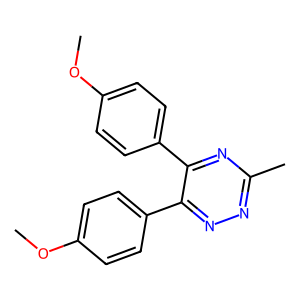


Top 10 Most Impactful Bit Combinations:

Combinations with structural information:

Bit Combination (np.int64(724), np.int64(1380)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 1380:


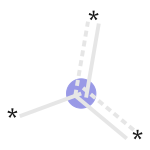


Bit Combination (np.int64(322), np.int64(689)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 322:


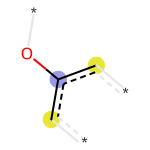


Bit Combination (np.int64(479), np.int64(978)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 978:


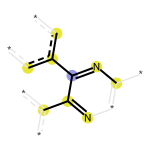


Bit Combination (np.int64(1160), np.int64(1903)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 1160:


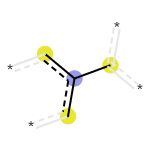


Bit Combination (np.int64(378), np.int64(457)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 378:


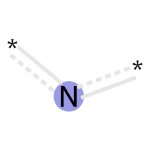


Bit Combination (np.int64(323), np.int64(331)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 323:


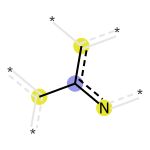


Bit Combination (np.int64(1481), np.int64(1722)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 1722:


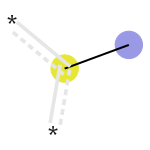


Bit Combination (np.int64(454), np.int64(650)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 454:


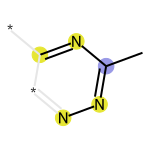


Bit Combination (np.int64(139), np.int64(714)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 139:


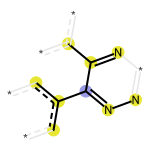


Bit Combination (np.int64(1126), np.int64(1613)):
Tanimoto Similarity: 0.9259
Times Flipped: 1

Substructure for bit 1126:


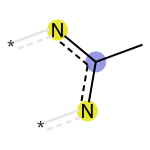

In [93]:
for molecule in ['anitrazafen']:
    for flip_count in [2]:
        analyze_single_molecule(dataframes_dict, molecule, flip_count)
        print("\n" + "="*50 + "\n")

In [94]:
def analyze_all_molecules(dataframes_dict):
    """
    Analyze SMILES strings across all molecules and flip counts
    """
    print("Analysis of Generated Molecules Across All Datasets:\n")
    all_results = {}
    
    # Define the flip counts we want to analyze
    flip_counts = [2]
    
    for molecule_name, molecule_dfs in dataframes_dict.items():
        print(f"\n{'='*50}")
        print(f"Analysis for {molecule_name.upper()}")
        print(f"{'='*50}\n")
        
        for n_flips in flip_counts:
            df = molecule_dfs[n_flips]  # Get the dataframe for this flip count
            
            print(f"\n{'-'*30}")
            print(f"Number of Bits Flipped: {n_flips}")
            print(f"{'-'*30}")
            
            # Get unique SMILES for this dataset
            unique_smiles = df['Generated_SMILES'].unique()
            
            # Analyze this specific dataset
            results_df = analyze_smiles_differences(unique_smiles, df)
            
            # Store results
            all_results[f"{molecule_name}_{n_flips}"] = results_df
    
    return all_results

def analyze_smiles_differences(smiles_list, full_dataset):
    """
    Analyze a list of SMILES strings and return detailed molecular information
    """
    results = []
    
    # Calculate frequencies from the full dataset
    total_count = len(full_dataset)
    smiles_counts = full_dataset['Generated_SMILES'].value_counts()
    
    # Create a mapping of SMILES to their associated flipped bits
    smiles_to_bits = {}
    for smiles in smiles_list:
        relevant_rows = full_dataset[full_dataset['Generated_SMILES'] == smiles]
        # Convert numpy arrays to lists and then sort
        flipped_bits = []
        for bits in relevant_rows['FlippedBitPositions']:
            if isinstance(bits, str):
                # Handle string representation of lists
                bits = eval(bits)
            elif isinstance(bits, np.ndarray):
                # Handle numpy arrays
                bits = bits.tolist()
            flipped_bits.extend(bits)
        smiles_to_bits[smiles] = sorted(list(set(flipped_bits)))
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Warning: Could not parse SMILES: {smiles}")
            continue
            
        # Calculate properties
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
        mw = Descriptors.ExactMolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        rotatable_bonds = Descriptors.NumRotatableBonds(mol)
        rings = Descriptors.RingCount(mol)
        aromatic_rings = sum(1 for ring in mol.GetRingInfo().AtomRings() 
                           if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring))
        
        # Calculate frequency
        count = smiles_counts.get(smiles, 0)
        frequency = (count / total_count) * 100
        
        results.append({
            'SMILES': smiles,
            'Molecular Formula': formula,
            'Molecular Weight': f"{mw:.2f}",
            'LogP': f"{logp:.2f}",
            'H-Bond Donors': hbd,
            'H-Bond Acceptors': hba,
            'Rotatable Bonds': rotatable_bonds,
            'Total Rings': rings,
            'Aromatic Rings': aromatic_rings,
            'Count': count,
            'Frequency': f"{frequency:.2f}%",
            'Flipped Bits': smiles_to_bits[smiles]
        })
    
    # Convert to DataFrame and sort by frequency
    df = pd.DataFrame(results)
    df = df.sort_values('Count', ascending=False)
    
    # Print summary
    for idx, row in df.iterrows():
        print(f"\nMolecule {idx + 1}:")
        print(f"SMILES: {row['SMILES']}")
        print(f"Formula: {row['Molecular Formula']}")
        print(f"Frequency: {row['Frequency']}")
        print(f"Flipped Bits: {', '.join(map(str, row['Flipped Bits']))}")
        print(f"MW: {row['Molecular Weight']} g/mol")
        print(f"LogP: {row['LogP']}")
        print(f"H-Bond Donors/Acceptors: {row['H-Bond Donors']}/{row['H-Bond Acceptors']}")
        print(f"Rotatable Bonds: {row['Rotatable Bonds']}")
        print(f"Rings (Total/Aromatic): {row['Total Rings']}/{row['Aromatic Rings']}")
        print()
    
    return df

In [ ]:
def analyze_all_molecules(dataframes_dict):
    """
    Analyze SMILES strings across all molecules and flip counts
    """
    print("Analysis of Generated Molecules Across All Datasets:\n")
    all_results = {}
    
    # Define all flip counts we want to analyze
    flip_counts = [2, 4, 8, 128, 1024]
    
    for molecule_name, molecule_dfs in dataframes_dict.items():
        print(f"\n{'='*50}")
        print(f"Analysis for {molecule_name.upper()}")
        print(f"{'='*50}\n")
        
        for n_flips in flip_counts:
            df = molecule_dfs[n_flips]  # Get the dataframe for this flip count
            
            print(f"\n{'-'*30}")
            print(f"Number of Bits Flipped: {n_flips}")
            print(f"{'-'*30}")
            
            # Get unique SMILES for this dataset
            unique_smiles = df['Generated_SMILES'].unique()
            
            # Analyze this specific dataset
            results_df = analyze_smiles_differences(unique_smiles, df, n_flips)
            
            # Store results
            all_results[f"{molecule_name}_{n_flips}"] = results_df
    
    return all_results

def analyze_smiles_differences(smiles_list, full_dataset, n_flips):
    """
    Analyze a list of SMILES strings and return detailed molecular information
    """
    results = []
    
    # Calculate frequencies from the full dataset
    total_count = len(full_dataset)
    smiles_counts = full_dataset['Generated_SMILES'].value_counts()
    
    # Create a mapping of SMILES to their associated flipped bits
    smiles_to_bits = {}
    for smiles in smiles_list:
        relevant_rows = full_dataset[full_dataset['Generated_SMILES'] == smiles]
        # Convert numpy arrays to lists and then sort
        flipped_bits = []
        for bits in relevant_rows['FlippedBitPositions']:
            if isinstance(bits, str):
                # Handle string representation of lists
                bits = eval(bits)
            elif isinstance(bits, np.ndarray):
                # Handle numpy arrays
                bits = bits.tolist()
            flipped_bits.extend(bits)
        smiles_to_bits[smiles] = sorted(list(set(flipped_bits)))
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Warning: Could not parse SMILES: {smiles}")
            continue
            
        # Calculate properties
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
        mw = Descriptors.ExactMolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        rotatable_bonds = Descriptors.NumRotatableBonds(mol)
        rings = Descriptors.RingCount(mol)
        aromatic_rings = sum(1 for ring in mol.GetRingInfo().AtomRings() 
                           if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring))
        
        # Calculate frequency
        count = smiles_counts.get(smiles, 0)
        frequency = (count / total_count) * 100
        
        results.append({
            'SMILES': smiles,
            'Molecular Formula': formula,
            'Molecular Weight': f"{mw:.2f}",
            'LogP': f"{logp:.2f}",
            'H-Bond Donors': hbd,
            'H-Bond Acceptors': hba,
            'Rotatable Bonds': rotatable_bonds,
            'Total Rings': rings,
            'Aromatic Rings': aromatic_rings,
            'Count': count,
            'Frequency': f"{frequency:.2f}%",
            'Flipped Bits': smiles_to_bits[smiles]
        })
    
    # Convert to DataFrame and sort by frequency
    df = pd.DataFrame(results)
    df = df.sort_values('Count', ascending=False)
    
    # Print summary with flip count in header
    print(f"\nResults for {n_flips} bit flips:")
    print(f"Total unique molecules: {len(df)}")
    print(f"Total samples: {total_count}")
    print("\nTop molecules by frequency:")
    
    for idx, row in df.iterrows():
        print(f"\nMolecule {idx + 1}:")
        print(f"SMILES: {row['SMILES']}")
        print(f"Formula: {row['Molecular Formula']}")
        print(f"Frequency: {row['Frequency']}")
        print(f"Flipped Bits: {', '.join(map(str, row['Flipped Bits']))}")
        print(f"MW: {row['Molecular Weight']} g/mol")
        print(f"LogP: {row['LogP']}")
        print(f"H-Bond Donors/Acceptors: {row['H-Bond Donors']}/{row['H-Bond Acceptors']}")
        print(f"Rotatable Bonds: {row['Rotatable Bonds']}")
        print(f"Rings (Total/Aromatic): {row['Total Rings']}/{row['Aromatic Rings']}")
        print("-" * 30)
    
    return df

In [95]:
# Analyze for flip counts of 2 bit flips
analyses = analyze_all_molecules(dataframes_dict)

Analysis of Generated Molecules Across All Datasets:


Analysis for ANITRAZAFEN


------------------------------
Number of Bits Flipped: 2
------------------------------

Molecule 1:
SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Formula: C18H17N3O2
Frequency: 97.46%
Flipped Bits: 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,